<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-description" data-toc-modified-id="Project-description-1">Project description</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2">Data Preparation</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-3">Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Trend-and-Seasonality" data-toc-modified-id="Trend-and-Seasonality-3.1">Trend and Seasonality</a></span></li><li><span><a href="#Feature-Generation" data-toc-modified-id="Feature-Generation-3.2">Feature Generation</a></span></li><li><span><a href="#Train-&amp;-Test-Split" data-toc-modified-id="Train-&amp;-Test-Split-3.3">Train &amp; Test Split</a></span></li></ul></li><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-4">Model Selection</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1">Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regression" data-toc-modified-id="Random-Forest-Regression-4.2">Random Forest Regression</a></span></li><li><span><a href="#KNeighborsRegressor" data-toc-modified-id="KNeighborsRegressor-4.3">KNeighborsRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.4">LGBMRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.5">CatBoost</a></span></li><li><span><a href="#Dummy-models" data-toc-modified-id="Dummy-models-4.6">Dummy models</a></span><ul class="toc-item"><li><span><a href="#Constant-Model" data-toc-modified-id="Constant-Model-4.6.1">Constant Model</a></span></li><li><span><a href="#Naive-Model" data-toc-modified-id="Naive-Model-4.6.2">Naive Model</a></span></li></ul></li></ul></li><li><span><a href="#Models-Comparison" data-toc-modified-id="Models-Comparison-5">Models Comparison</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, the amount of taxi orders for the next hour needs to be predicted.<br>
<b>The task</b> is to develop a model for taxi orders predictions with RMSE no more than 48. The data needs to be re-sampled by one hour.<br>
<b>Data description</b>
Time series data was provided and it includes:<br>
<i>datetime</i> — a time stamp<br>
<i>num_orders</i> — number of order per a time stamp<br>

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from IPython.display import Image
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)

In [3]:
print('Begining of the period', df.index.min(), 'End of the period', df.index.max())

Begining of the period 2018-03-01 00:00:00 End of the period 2018-08-31 23:50:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data set contains 26496 rows and there are no missing values. We set time stamp data as indices and sorted the data by the time stamp in chronological order. The observed data is for the period of time from March 1st to August 31st.

# Data Analysis

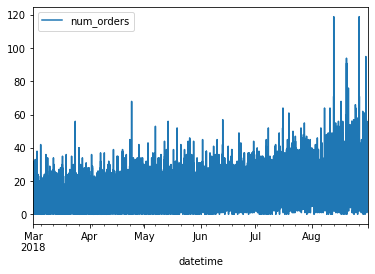

In [5]:
df.plot();

The project's requirement is to re-sample data by one hour.

In [6]:
df = df.resample('1H').sum()

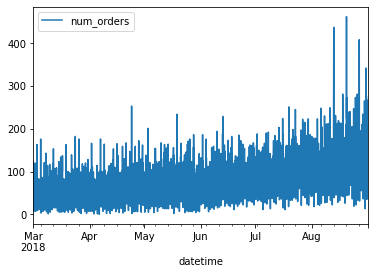

In [7]:
df.plot();

The graph looks still pretty dense after re-sampling by one hour. For the better understanding of what features we need, we might look at different levels of re-sampling later.

## Trend and Seasonality

In [8]:
decomposed = seasonal_decompose(df)

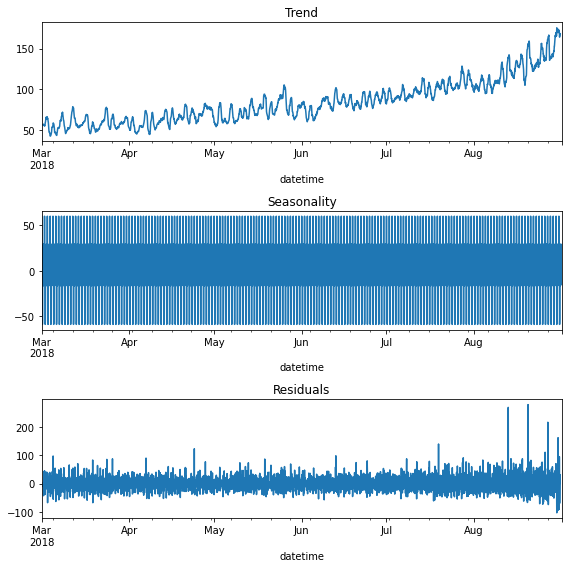

In [9]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()    

Let's take at look at amplitude of swings of the seasonality up close. To reduce the frequency of lines we might need to create a copy of the data set and re-sample it by one day.

In [10]:
df_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_day)

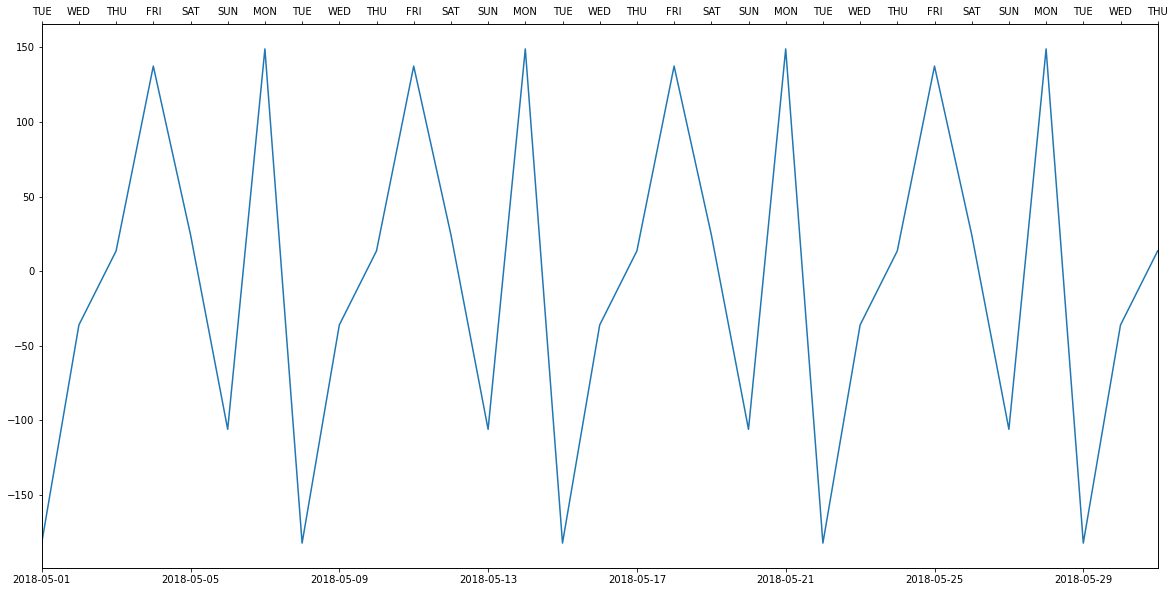

In [11]:
Y = decomposed.seasonal['2018-05-01':'2018-05-31']
x = decomposed.seasonal['2018-05-01':'2018-05-31'].index
weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU', 4:'FRI', 5:'SAT', 6:'SUN'}
dow = decomposed.seasonal['2018-05-01':'2018-05-31'].index.dayofweek.map(weekday_map)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(len(x)), minor=False)
ax2.set_xticklabels(dow)
ax1.set_xlim(min(x), max(x))
ax1.plot(x, Y);

There is obvious seasonality trend in the data: the peak of taxi rides is on Mondays, the second highest peak is on Fridays. That is why we will need to create a day of the week feature.

## Feature Generation

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [13]:
df = make_features(df, 5, 7)

In [14]:
df.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,42.571429


## Train & Test Split

Now that the new features are ready, let's split the data into train and test sets.

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
train_X = train.drop(['num_orders'], axis=1)
test_X = test.drop(['num_orders'], axis=1)
train_y = train['num_orders']
test_y = test['num_orders']

In order to find best hyper-parameters we will perform grid search cross validation. Since we have time-series data we will use time-aware cross validation technique, which can be explained as follows:

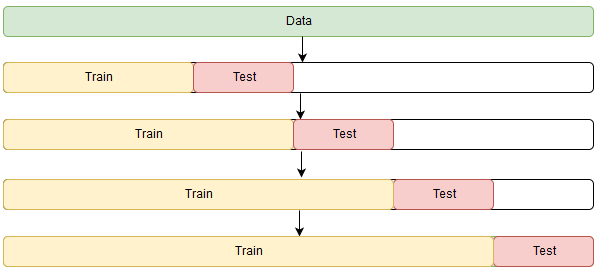

In [16]:
Image(filename='time_aware_cv.png')

Source: https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

In [17]:
time_split = TimeSeriesSplit(n_splits=3)

# Model Selection

## Linear Regression

In [18]:
lm = LinearRegression()
lm.fit(train_X, train_y)

LinearRegression()

In [19]:
%%time
lm_predictions_test = lm.predict(test_X)

CPU times: user 9.32 ms, sys: 930 µs, total: 10.2 ms
Wall time: 2.63 ms


In [20]:
lm_rmse_test = round(mean_squared_error(test_y, lm_predictions_test)**0.5, 2)
print('RMSE on test:', lm_rmse_test)

RMSE on test: 47.52


## Random Forest Regression

In [21]:
rfr = RandomForestRegressor()

In [22]:
param_grid = { 
    'n_estimators': [10, 25, 50, 75, 100],
    'max_depth' : [i for i in range(3,15,3)]
}

In [23]:
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=time_split, scoring='neg_root_mean_squared_error')
CV_rfr.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 25, 50, 75, 100]},
             scoring='neg_root_mean_squared_error')

In [24]:
CV_rfr.best_params_

{'max_depth': 12, 'n_estimators': 50}

In [25]:
-CV_rfr.best_score_

25.184551050432002

In [26]:
%%time
rfr_best_pred_test = CV_rfr.predict(test_X)

CPU times: user 8.25 ms, sys: 1.13 ms, total: 9.38 ms
Wall time: 8.28 ms


In [27]:
rfr_rmse_test = round(mean_squared_error(test_y, rfr_best_pred_test)**0.5, 2)
print('RMSE on test:', rfr_rmse_test)

RMSE on test: 45.76


## KNeighborsRegressor

In [28]:
knn = KNeighborsRegressor()

In [29]:
param_grid = {
        'n_neighbors' : range(1,5,1),
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
knn_CV = GridSearchCV(estimator = knn, param_grid = param_grid, cv=time_split, scoring = 'neg_root_mean_squared_error')
knn_CV.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 5)},
             scoring='neg_root_mean_squared_error')

In [30]:
knn_CV.best_params_

{'algorithm': 'auto', 'n_neighbors': 4}

In [31]:
-knn_CV.best_score_

33.310054112409034

In [32]:
%%time
knn_best_pred_test = knn_CV.predict(test_X)

CPU times: user 42.1 ms, sys: 8.05 ms, total: 50.2 ms
Wall time: 12.5 ms


In [33]:
knn_rmse_test = round(mean_squared_error(test_y, knn_best_pred_test)**0.5, 2)
print('RMSE on test:', knn_rmse_test)

RMSE on test: 57.57


## LGBMRegressor

In [34]:
lgbm_model = LGBMRegressor()

In [35]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 400], #Number of boosted trees to fit.
    'max_depth': [5, 10, 15, 20, 25] #Maximum tree depth for base learners, <=0 means no limit.
}

In [36]:
grid_search_lgbm = GridSearchCV(estimator=lgbm_model,
                                param_grid=param_grid,
                                cv=time_split,
                                scoring='neg_root_mean_squared_error')

In [37]:
grid_search_lgbm.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [5, 10, 15, 20, 25],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_root_mean_squared_error')

In [38]:
grid_search_lgbm.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

In [39]:
lgbm_best = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=100)

In [40]:
lgbm_best.fit(train_X, train_y)

LGBMRegressor(learning_rate=0.05, max_depth=10)

In [41]:
%%time
lgbm_predictions_test = lgbm_best.predict(test_X)

CPU times: user 25.2 ms, sys: 4.77 ms, total: 30 ms
Wall time: 5.16 ms


In [42]:
lgbm_rmse_test = round(mean_squared_error(test_y, lgbm_predictions_test)**0.5, 2)
print('RMSE on test:', lgbm_rmse_test)

RMSE on test: 45.39


## CatBoost

In [43]:
catboost = CatBoostRegressor()

In [44]:
param_grid = {'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.15],
        'depth': [6, 8, 10],
        'l2_leaf_reg': [1, 3, 5]}

In [45]:
grid_search_result = catboost.grid_search(param_grid, X=train_X, y=train_y, cv=time_split)

0:	learn: 73.1823120	test: 99.2036382	best: 99.2036382 (0)	total: 56.5ms	remaining: 5.6s
1:	learn: 70.1485756	test: 95.5931749	best: 95.5931749 (1)	total: 62.2ms	remaining: 3.04s
2:	learn: 67.2819918	test: 92.6287629	best: 92.6287629 (2)	total: 66.5ms	remaining: 2.15s
3:	learn: 64.6433207	test: 89.4009714	best: 89.4009714 (3)	total: 71.8ms	remaining: 1.72s
4:	learn: 62.0597538	test: 86.4865719	best: 86.4865719 (4)	total: 76.1ms	remaining: 1.44s
5:	learn: 59.5793980	test: 83.6820250	best: 83.6820250 (5)	total: 79.2ms	remaining: 1.24s
6:	learn: 57.1685216	test: 80.9777714	best: 80.9777714 (6)	total: 82.7ms	remaining: 1.1s
7:	learn: 55.0329115	test: 78.2099326	best: 78.2099326 (7)	total: 86.3ms	remaining: 993ms
8:	learn: 52.9825466	test: 75.7136500	best: 75.7136500 (8)	total: 89.6ms	remaining: 906ms
9:	learn: 51.0039000	test: 73.2851104	best: 73.2851104 (9)	total: 93.5ms	remaining: 842ms
10:	learn: 49.2558679	test: 71.1890139	best: 71.1890139 (10)	total: 97.6ms	remaining: 789ms
11:	learn:

limit_output extension: Maximum message size of 10000 exceeded with 10759 characters

In [46]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 3, 'iterations': 200, 'learning_rate': 0.1}

In [47]:
catboost_best = CatBoostRegressor(depth=6, l2_leaf_reg=3, iterations=200, learning_rate=0.1)

In [48]:
catboost_best.fit(train_X, train_y)

0:	learn: 34.0832901	total: 1.12ms	remaining: 222ms
1:	learn: 32.5959544	total: 2.41ms	remaining: 238ms
2:	learn: 31.3529366	total: 4.41ms	remaining: 289ms
3:	learn: 30.4757209	total: 5.91ms	remaining: 290ms
4:	learn: 29.5272550	total: 7.21ms	remaining: 281ms
5:	learn: 28.5724114	total: 8.59ms	remaining: 278ms
6:	learn: 27.8865087	total: 9.77ms	remaining: 269ms
7:	learn: 27.2200184	total: 11ms	remaining: 264ms
8:	learn: 26.6340578	total: 12.2ms	remaining: 260ms
9:	learn: 26.2000567	total: 13.4ms	remaining: 255ms
10:	learn: 25.8164796	total: 14.7ms	remaining: 253ms
11:	learn: 25.4333100	total: 15.7ms	remaining: 246ms
12:	learn: 25.1019714	total: 16.8ms	remaining: 241ms
13:	learn: 24.8130296	total: 18.1ms	remaining: 240ms
14:	learn: 24.5090706	total: 19.4ms	remaining: 240ms
15:	learn: 24.2802326	total: 20.8ms	remaining: 240ms
16:	learn: 24.0664830	total: 22.2ms	remaining: 239ms
17:	learn: 23.8255257	total: 23.6ms	remaining: 238ms
18:	learn: 23.6775256	total: 24.9ms	remaining: 237ms
19:	l

limit_output extension: Maximum message size of 10000 exceeded with 10622 characters

In [49]:
%%time
catboost_predictions_test = catboost_best.predict(test_X)

CPU times: user 3.81 ms, sys: 1.61 ms, total: 5.42 ms
Wall time: 2.93 ms


In [50]:
cat_rmse_test = round(mean_squared_error(test_y, catboost_predictions_test)**0.5, 2)
print('RMSE on test:', cat_rmse_test)

RMSE on test: 45.68


## Dummy models

### Constant Model

In [51]:
pred_mean = np.ones(test_y.shape) * train_y.mean()
constant_rmse = round(mean_squared_error(test_y, pred_mean)**0.5)
print('RMSE on test:', constant_rmse)

RMSE on test: 74


### Naive Model

This model's prediction is a preceding value.

In [52]:
pred_previous = test_y.shift()
pred_previous.iloc[0] = train_y.iloc[-1]
naive_rmse = round(mean_squared_error(test_y, pred_previous)**0.5)
print('RMSE on test:', naive_rmse)

RMSE on test: 53


# Models Comparison

In [53]:
d = {'RSME on test': [lm_rmse_test, rfr_rmse_test, knn_rmse_test, lgbm_rmse_test, 
                      cat_rmse_test, constant_rmse, naive_rmse],
    'Prediction time, ms': [2.41, 11.5, 14.7, 4.28, 1.98, '--', '--']}

final = pd.DataFrame(data=d, index=['Linear Regression', 'Random Forest Regression', 'KNeighbors Regressor',
                                    'LightGBMRegressor', 'CatBoost', 'Constant Model', 'Naive Model'])
display(final)

,RSME on test,"Prediction time, ms"
Linear Regression,47.52,2.41
Random Forest Regression,45.76,11.5
KNeighbors Regressor,57.57,14.7
LightGBMRegressor,45.39,4.28
CatBoost,45.68,1.98
Constant Model,74.00,--
Naive Model,53.00,--


# Conclusion

 1. We loaded the data and set the time stamp column as indices. We sorted the data set in chronological order.<br>
 2. We checked trend and seasonality in the data. There is an upward trend in number in rides from March to August. Also, the data has weekly seasonality: the pattern in number of rides repeats every week with two peaks: Mondays and Fridays.
 3. We generated additional features to train models: month, day, day of the week, hour and five lag columns.<br>
 4. We tested five models. Our target RMSE metric was set to be no more than 48. Four models out of five demonstrate acceptable RMSE values. The only model whose RMSE is higher is the KNeighbors Resgressot, its prediction time is the highest too. The Random Forest Regressor gives the best RMSE, but its run time is quite high. The best model for our task is the Catboost with RMSE of 45.68 and runtime 1.98 ms.